# Convolutional Neural Networks (LeNet)


## LeNet

At a high level, LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully-connected layers:
 
![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](../img/lenet.svg)

In [26]:
#EX1:
#Change the average pooling with the max pooling
#https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
    
from d2l import torch as d2l
import torch
from torch import nn

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    
    #EX1:
    nn.AvgPool2d(kernel_size=2, stride=2),
    #https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
    #nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    
    #EX1:
    nn.AvgPool2d(kernel_size=2, stride=2),
    #https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
    #nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [27]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
 
for layer in net:
    print(layer.__class__.__name__,'output shape: \t',X.shape)
    

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 1, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 1, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 1, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 1, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 1, 28, 28])
Flatten output shape: 	 torch.Size([1, 1, 28, 28])
Linear output shape: 	 torch.Size([1, 1, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 1, 28, 28])
Linear output shape: 	 torch.Size([1, 1, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 1, 28, 28])
Linear output shape: 	 torch.Size([1, 1, 28, 28])


In [63]:
#EX2:
#Modify the net architecture:

from d2l import torch as d2l
import torch
from torch import nn

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)


complex_net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=11, padding=5), nn.ReLU(), #kernel size: 5 ==> 11
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6, 12, kernel_size=5, padding=2), nn.ReLU(), #add a NEW LAYER
    nn.AvgPool2d(kernel_size=2),
    
    nn.Conv2d(12, 18, kernel_size=3, padding=1), nn.ReLU(), #kernel size: 5==> 3
    nn.AvgPool2d(kernel_size=2),
    
    nn.Flatten(),
    nn.Linear(18 * 3*3, 150), nn.ReLU(), #nb nodes 120==> 150
    nn.Linear(150, 100), nn.ReLU(), #nb. nodes 84==> 100
    nn.Linear(100, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in complex_net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)


Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 12, 14, 14])
ReLU output shape: 	 torch.Size([1, 12, 14, 14])
AvgPool2d output shape: 	 torch.Size([1, 12, 7, 7])
Conv2d output shape: 	 torch.Size([1, 18, 7, 7])
ReLU output shape: 	 torch.Size([1, 18, 7, 7])
AvgPool2d output shape: 	 torch.Size([1, 18, 3, 3])
Flatten output shape: 	 torch.Size([1, 162])
Linear output shape: 	 torch.Size([1, 150])
ReLU output shape: 	 torch.Size([1, 150])
Linear output shape: 	 torch.Size([1, 100])
ReLU output shape: 	 torch.Size([1, 100])
Linear output shape: 	 torch.Size([1, 10])


In [64]:
#EX3:
#Loader of the MNIST dataset

import torchvision
from torchvision import transforms
from torch.utils import data

def load_data_mnist(batch_size, resize=None): 
    """Download MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True),
            data.DataLoader(mnist_test, batch_size, shuffle=False))

## Training

In [28]:
batch_size = 256

#EX3: load MNIST instead of Fadhion-MNIST
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
#train_iter, test_iter = load_data_mnist(batch_size=batch_size)



In [29]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [30]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Model parameter INITIALIZATION
    net.apply(init_weights)
    print('training on', device)
    net.to(device) # MOVE the net to the GPU (if available)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.989, train acc 0.622, test acc 0.636
56948.7 examples/sec on cuda:0


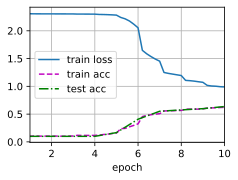

In [31]:
#EX2:
#Change the hyperparaters
lr, num_epochs = 0.1, 10

train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
#EX4:
x = next(iter(test_iter))[0][2].cuda()
print(x.shape)
for l, l_num in zip(net.children(), range(3)):
    print(l)
    x = l(x)

print(x.shape)

import matplotlib.pyplot as plt 

plt.imshow(x.cpu().detach().squeeze().permute(1, 2, 0)[..., 3:])

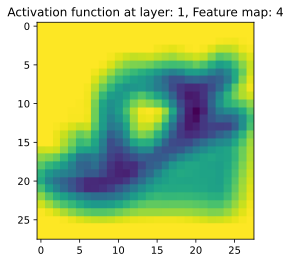

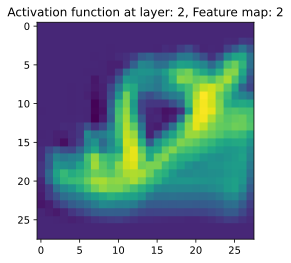

In [79]:
#EX4:
import matplotlib.pyplot as plt 
import random

def show_activation(net, X):
 
    for layer, n_layer in zip(net, range(3)):
        X = layer(X)
        if n_layer == 1 or n_layer == 2:
            Y = X.cpu().detach().squeeze().permute(1, 2, 0)
            n_featMaps = Y.shape[2]
            featMap = random.randint(0, n_featMaps-1)  #randomly choose one feature map in the current layer     
            plt.imshow(Y[...,featMap])  
            plt.title("Activation function at layer: " + str(n_layer) + ", Feature map: " + str(featMap))
            plt.show()
        
testImg = random.randint(0, batch_size-1)  #randomly choose one test image in the mini-batch      
X = next(iter(test_iter))[0][testImg].cuda() 
show_activation(net, X)


## Summary

* A CNN is a network that employs convolutional layers.
* In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.
* In a CNN, convolutional layers are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.
* In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully-connected layers prior to emitting output.
* LeNet was arguably the first successful deployment of such a network.

## Exercises

1. Replace the average pooling with max pooling. What happens?
1. Try to construct a more complex network based on LeNet to improve its accuracy.
    1. Adjust the convolution window size.
    1. Adjust the number of output channels.
    1. Adjust the activation function (e.g., ReLU).
    1. Adjust the number of convolution layers.
    1. Adjust the number of fully connected layers.
    1. Adjust the learning rates and other training details (e.g., initialization and number of epochs.)
1. Try out the improved network on the original MNIST dataset.
1. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).

